### Import Libraries

In [1]:
import pandas as pd
import random
import os
import numpy as np
from functools import partial
from lightgbm import LGBMRegressor
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [3]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Feature
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [4]:
def zero_variance(df):
    """
    @Description: check for zero_variance
    @Param1: df, pandas dataframe
    @Return: names of the columns with zero variance
    """
    result = []
    for col in df.columns:
        if df[col].var() == 0:
            result.append(col)
    return result

In [5]:
def get_top_correlation(df, n=10):
    """
    @Description: print out top correlated features
    @Param1: df, pandas dataframe
    @Param2: n, number of lines to print 
    @Return: pandas series
    """
    pairs = set()
    for idx1 in range(0, df.shape[1]):
        for idx2 in range(0, idx1+1):
            pairs.add((df.columns[idx1], df.columns[idx2]))
    corr = df.corr().abs().unstack()
    corr = corr.drop(labels=pairs).sort_values(ascending=False)
    return corr[0:n]

In [6]:
def lg_nrmse(gt, preds):
    """
    @Description: Metric used in this project
    @Params1: gt, pandas dataframe
    @Param2: preds, pandas dataframe
    @Return: nrmse score
    """
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    preds = pd.DataFrame(preds)
    all_nrmse = []
    for idx in range(0,14):
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [23]:
train_x = pd.read_csv('data/train.csv')

test_x = pd.read_csv('data/test.csv')
train_x, train_y = dataset_split_X_y(train_x)


y_feature_spec_info = pd.read_csv('data/meta/y_feature_spec_info.csv')

In [8]:
train_y.head()

,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,2.056,1.456,1.680,10.502,29.632,16.083,4.276,-25.381,-25.529,-22.769,23.792,-25.470,-25.409,-25.304
1,1.446,1.184,1.268,18.507,33.179,16.736,3.229,-26.619,-26.523,-22.574,24.691,-26.253,-26.497,-26.438
2,1.251,0.665,0.782,14.082,31.801,17.080,2.839,-26.238,-26.216,-22.169,24.649,-26.285,-26.215,-26.370
3,1.464,1.079,1.052,16.975,34.503,17.143,3.144,-25.426,-25.079,-21.765,24.913,-25.254,-25.021,-25.345
4,0.983,0.646,0.689,15.047,32.602,17.569,3.138,-25.376,-25.242,-21.072,25.299,-25.072,-25.195,-24.974


In [16]:
group1 = ['X_14', 'X_15', 'X_16', 'X_17', 'X_18']
group2 = ['X_19', 'X_20', 'X_21', 'X_22']
group3 = ['X_24', 'X_25', 'X_26', 'X_27', 'X_28', 'X_29']
group4 = ['X_41','X_42', 'X_43', 'X_44']
group5 = ['X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56']

In [17]:
lst = []
for k in range(len(train_x)):
    for i in group1:
        max_ = 0
        min_ = 1000000
        if max_ < max(train_x[i]):
            max_ = max(train_x[i])
        if min_ > min(train_x[i]):
            min_ = min(train_x[i])
    lst.append(abs(max_ - min_))

X_57 = pd.DataFrame(lst)
X_57 = pd.concat([X_57, pd.DataFrame(lst)], axis=1)


KeyboardInterrupt: 

In [ ]:
lst = []
for k in range(len(train_x)):
    for i in group2:
        max_ = 0
        min_ = 1000000
        if max_ < max(train_x[i]):
            max_ = max(train_x[i])
        if min_ > min(train_x[i]):
            min_ = min(train_x[i])
        lst.append(abs(max_ - min_))

X_58 = pd.DataFrame(lst)
X_58 = pd.concat([X_57, pd.DataFrame(lst)], axis=1)


In [ ]:
lst = []
for k in range(len(train_x)):
    for i in group3:
        max_ = 0
        min_ = 1000000
        if max_ < max(train_x[i]):
            max_ = max(train_x[i])
        if min_ > min(train_x[i]):
            min_ = min(train_x[i])
        lst.append(abs(max_ - min_))

X_59 = pd.DataFrame(lst)
X_59 = pd.concat([train_x, pd.DataFrame(lst)], axis=1)


In [ ]:
lst = []
for k in range(len(train_x)):
    for i in group4:
        max_ = 0
        min_ = 1000000
        if max_ < max(train_x[i]):
            max_ = max(train_x[i])
        if min_ > min(train_x[i]):
            min_ = min(train_x[i])
        lst.append(abs(max_ - min_))

X_60 = pd.DataFrame(lst)

In [ ]:
lst = []
for k in range(len(train_x)):
    for i in group5:
        max_ = 0
        min_ = 1000000
        if max_ < max(train_x[i]):
            max_ = max(train_x[i])
        if min_ > min(train_x[i]):
            min_ = min(train_x[i])
        lst.append(abs(max_ - min_))

X_61 = pd.DataFrame(lst)

In [9]:
train_spec_df = y_feature_spec_info
df_indicator_y = pd.DataFrame()
for idx in range(len(train_spec_df.Feature)):
    if train_spec_df.Feature[idx] in train_y.columns:
        y_series = ~train_y[train_spec_df.Feature[idx]].between(train_spec_df.iloc[idx, :].Min, train_spec_df.iloc[idx, :].Max)
        df_indicator_y = pd.concat([df_indicator_y, y_series.astype(int)], axis = 1)

In [10]:
normal_data = df_indicator_y[df_indicator_y==0]
spec_data = df_indicator_y[df_indicator_y==1]

In [11]:
spec_data.count()

Y_01    1476
Y_02     558
Y_03     464
Y_04     500
Y_05      91
Y_06      10
Y_07    1822
Y_08      19
Y_09      19
Y_10       5
Y_11       3
Y_12      16
Y_13      15
Y_14      13
dtype: int64

In [12]:
train_x_spec_y_01 = train_x[spec_data['Y_02'] == 1]
train_x_normal_y_01 = train_x[normal_data['Y_02'] == 0]

In [14]:
for k in train_y.columns:
    train_x_spec_y_01 = train_x[spec_data[k] == 1]
    train_x_normal_y_01 = train_x[normal_data[k] == 0]
    print(k)
    for i in train_x.columns:
        if max(train_x_normal_y_01[i]) < max(train_x_spec_y_01[i]):
            print('max :' ,i)
        if min(train_x_normal_y_01[i]) > min(train_x_spec_y_01[i]) :
            print('min :' ,i)
    print()




Y_01
min : X_14
min : X_15
min : X_16
min : X_18
max : X_51

Y_02
min : X_49

Y_03
min : X_49

Y_04
max : X_37
max : X_54

Y_05

Y_06

Y_07
min : X_41

Y_08

Y_09

Y_10

Y_11

Y_12

Y_13

Y_14



In [15]:
train_x_normal_y_01.iloc[:,10:20].describe()

,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20
count,39594.000000,39594.000000,39594.000000,39594.000000,39594.000000,39594.000000,39594.000000,39594.000000,39594.000000,39594.000000
mean,0.000366,4.373230,0.143335,13.372203,13.381916,13.463860,13.512590,13.449264,3.240250,3.184512
std,0.014148,0.021808,0.025332,0.029867,0.029468,0.036741,0.023436,0.029094,0.110484,0.105266
min,0.000000,4.270000,0.050000,13.150000,13.230000,13.260000,13.410000,13.260000,2.860000,2.830000
25%,0.000000,4.360000,0.130000,13.350000,13.360000,13.440000,13.500000,13.430000,3.160000,3.100000
50%,0.000000,4.370000,0.140000,13.370000,13.380000,13.470000,13.510000,13.450000,3.220000,3.180000
75%,0.000000,4.390000,0.160000,13.390000,13.410000,13.490000,13.530000,13.470000,3.310000,3.270000
max,0.700000,4.490000,0.280000,13.490000,13.500000,13.610000,13.610000,13.570000,3.750000,3.670000


In [16]:
train_x_spec_y_01.iloc[:,10:20].describe()

,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20
count,13.0,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.0,4.366923,0.143846,13.368462,13.375385,13.463077,13.509231,13.447692,3.176154,3.126923
std,0.0,0.013775,0.030149,0.026092,0.030445,0.038597,0.023260,0.027127,0.083620,0.090865
min,0.0,4.340000,0.100000,13.330000,13.330000,13.410000,13.480000,13.410000,3.090000,3.030000
25%,0.0,4.360000,0.120000,13.350000,13.350000,13.430000,13.490000,13.430000,3.130000,3.060000
50%,0.0,4.370000,0.140000,13.370000,13.390000,13.470000,13.510000,13.450000,3.150000,3.110000
75%,0.0,4.380000,0.160000,13.390000,13.400000,13.480000,13.520000,13.470000,3.210000,3.150000
max,0.0,4.380000,0.190000,13.410000,13.410000,13.530000,13.550000,13.490000,3.420000,3.360000


In [17]:
train_x_normal_y_01.iloc[:,20:30].describe()

,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30
count,39594.000000,39594.000000,39594.0,39594.000000,39594.000000,39594.000000,39594.000000,39594.000000,39594.000000,39594.000000
mean,3.174288,3.232693,1.0,2.115674,2.093895,2.090377,2.098248,2.118591,2.173727,1.378992
std,0.106865,0.108984,0.0,0.032443,0.033150,0.038517,0.038060,0.042783,0.046691,0.030408
min,2.830000,2.850000,1.0,1.830000,1.960000,1.980000,1.990000,1.930000,2.020000,0.570000
25%,3.090000,3.140000,1.0,2.090000,2.070000,2.060000,2.070000,2.090000,2.140000,1.370000
50%,3.160000,3.230000,1.0,2.120000,2.090000,2.090000,2.090000,2.120000,2.170000,1.370000
75%,3.250000,3.320000,1.0,2.140000,2.120000,2.120000,2.120000,2.140000,2.200000,1.380000
max,3.680000,3.790000,1.0,2.350000,2.350000,2.350000,2.350000,2.350000,2.360000,2.110000


In [18]:
train_x_spec_y_01.iloc[:,20:30].describe()

,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30
count,13.000000,13.000000,13.0,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,3.121538,3.170000,1.0,2.116154,2.093846,2.090000,2.101538,2.127692,2.173846,1.387692
std,0.108155,0.079791,0.0,0.021424,0.027850,0.020412,0.024099,0.040652,0.040319,0.040652
min,3.000000,3.060000,1.0,2.090000,2.040000,2.070000,2.060000,2.060000,2.120000,1.350000
25%,3.080000,3.120000,1.0,2.100000,2.080000,2.070000,2.080000,2.110000,2.150000,1.370000
50%,3.090000,3.170000,1.0,2.110000,2.100000,2.090000,2.100000,2.130000,2.170000,1.380000
75%,3.140000,3.190000,1.0,2.130000,2.120000,2.110000,2.130000,2.140000,2.190000,1.380000
max,3.450000,3.370000,1.0,2.160000,2.130000,2.130000,2.130000,2.230000,2.260000,1.510000


In [69]:
train_x_normal_y_01.iloc[:,30:40].describe()

,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40
count,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000
mean,1.571179,1.362961,1.595846,12.950250,12.920309,12.941730,12.919113,-15.904671,-15.890222,-16.572931
std,0.074738,0.030060,0.107967,0.044023,0.052232,0.047839,0.052295,0.594186,0.747688,0.343985
min,0.600000,0.570000,0.610000,12.840000,12.810000,12.840000,12.810000,-17.090000,-17.090000,-17.720000
25%,1.530000,1.350000,1.550000,12.920000,12.870000,12.900000,12.870000,-16.160000,-16.160000,-16.810000
50%,1.550000,1.360000,1.570000,12.960000,12.910000,12.950000,12.910000,-15.990000,-15.990000,-16.640000
75%,1.600000,1.370000,1.610000,12.990000,12.970000,12.980000,12.970000,-15.750000,-15.750000,-16.400000
max,7.210000,2.450000,7.810000,13.080000,13.090000,13.090000,13.080000,32.230000,-2.650000,-14.800000


In [70]:
train_x_spec_y_01.iloc[:,30:40].describe()

,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40
count,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,1.568495,1.360663,1.587151,12.951685,12.922724,12.941631,12.920914,-15.838423,-15.844373,-16.518315
std,0.057227,0.020243,0.112019,0.044521,0.052634,0.047217,0.052147,0.673639,0.670276,0.374343
min,1.500000,1.330000,0.610000,12.850000,12.830000,12.850000,12.810000,-16.760000,-16.760000,-17.360000
25%,1.530000,1.350000,1.550000,12.920000,12.870000,12.900000,12.880000,-16.140000,-16.140000,-16.790000
50%,1.550000,1.360000,1.570000,12.960000,12.925000,12.950000,12.920000,-15.940000,-15.960000,-16.605000
75%,1.590000,1.370000,1.590000,12.990000,12.970000,12.980000,12.970000,-15.640000,-15.650000,-16.290000
max,1.880000,1.470000,2.160000,13.040000,13.060000,13.040000,13.030000,-2.650000,-2.650000,-15.340000


In [71]:
train_x_normal_y_01.iloc[:,40:50].describe()

,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
count,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.0,39049.0,39049.000000,39049.000000
mean,21.186992,21.059368,21.203696,21.160097,0.154520,1468.276166,1.0,1.0,16678.583539,130.782024
std,0.031099,0.040272,0.047227,0.042166,0.046989,2.120836,0.0,0.0,8552.008319,5.991171
min,20.730000,20.790000,20.800000,20.930000,0.000000,1457.000000,1.0,1.0,3382.630000,21.800000
25%,21.170000,21.030000,21.170000,21.130000,0.120000,1469.000000,1.0,1.0,13108.630000,126.956647
50%,21.190000,21.060000,21.200000,21.160000,0.150000,1469.000000,1.0,1.0,15278.930000,130.732472
75%,21.210000,21.090000,21.240000,21.190000,0.190000,1469.000000,1.0,1.0,17564.730000,134.547360
max,21.620000,21.440000,21.410000,21.320000,0.420000,1469.000000,1.0,1.0,114563.630000,162.619458


In [72]:
train_x_spec_y_01.iloc[:,40:50].describe()

,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
count,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.0,558.0,558.000000,558.000000
mean,21.186953,21.056971,21.204337,21.160771,0.157849,1468.215054,1.0,1.0,16560.053513,130.252055
std,0.033132,0.041350,0.046088,0.042851,0.045367,2.169725,0.0,0.0,10618.710723,5.878046
min,21.080000,20.890000,21.040000,21.000000,0.040000,1457.000000,1.0,1.0,3341.830000,113.547627
25%,21.170000,21.030000,21.170000,21.130000,0.120000,1469.000000,1.0,1.0,12175.205000,126.111388
50%,21.190000,21.060000,21.210000,21.160000,0.160000,1469.000000,1.0,1.0,14783.880000,130.313973
75%,21.210000,21.080000,21.230000,21.200000,0.190000,1469.000000,1.0,1.0,17264.080000,133.887299
max,21.510000,21.250000,21.370000,21.240000,0.290000,1469.000000,1.0,1.0,114211.130000,150.277661


In [73]:
train_x_normal_y_01.describe()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
count,39049.000000,39049.000000,39049.000000,39049.0,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,...,39049.0,39049.0,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000,39049.000000
mean,68.411610,103.320167,68.816570,1.0,102.337957,70.595443,29.394517,164.448757,225.514783,0.002407,...,1.0,1.0,16678.583539,130.782024,131.459133,138.587340,127.995251,128.017585,137.886895,128.446802
std,2.658364,0.000373,5.154366,0.0,0.548553,2.260763,7.258563,220.629270,66.638349,0.085533,...,0.0,0.0,8552.008319,5.991171,5.941484,6.474068,5.712359,5.441066,6.558856,5.450783
min,56.268000,103.320000,56.470000,1.0,101.774000,61.726000,14.140000,38.460000,37.580000,0.000000,...,1.0,1.0,3382.630000,21.800000,21.910000,23.100000,21.330000,21.340000,22.980000,21.410000
25%,66.465000,103.320000,65.070000,1.0,101.949000,68.864000,27.890000,105.960000,188.630000,0.000000,...,1.0,1.0,13108.630000,126.956647,127.668461,134.471696,124.379934,124.696049,133.751523,125.140644
50%,68.504000,103.320000,67.270000,1.0,102.006000,69.884000,28.840000,115.040000,234.580000,0.000000,...,1.0,1.0,15278.930000,130.732472,131.356266,138.524881,128.027021,128.103878,137.901829,128.415753
75%,69.524000,103.320000,71.770000,1.0,103.144000,71.923000,29.870000,132.630000,263.960000,0.000000,...,1.0,1.0,17564.730000,134.547360,135.173489,142.704385,131.618765,131.499576,142.075490,131.842556
max,84.820000,103.321000,89.170000,1.0,103.160000,87.219000,163.860000,2387.440000,637.490000,3.600000,...,1.0,1.0,114563.630000,162.619458,194.513195,173.438623,152.406630,175.052891,170.155980,155.277538


In [74]:
train_x_spec_y_01.describe()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
count,558.000000,558.000000,558.000000,558.0,558.000000,558.00000,558.000000,558.000000,558.000000,558.000000,...,558.0,558.0,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,68.442138,103.320149,69.511039,1.0,102.284437,70.72097,30.315323,164.488692,217.187832,0.005376,...,1.0,1.0,16560.053513,130.252055,131.337355,138.605408,127.794313,127.770899,137.731848,128.043417
std,2.485748,0.000356,4.877934,0.0,0.531973,2.19123,11.601906,204.086726,72.760905,0.127000,...,0.0,0.0,10618.710723,5.878046,5.412467,6.170294,5.770202,4.909347,6.064247,4.953707
min,58.307000,103.320000,60.270000,1.0,101.815000,63.76600,24.960000,58.380000,37.580000,0.000000,...,1.0,1.0,3341.830000,113.547627,108.960072,114.213213,109.122007,113.056164,120.323552,101.781635
25%,66.465000,103.320000,65.770000,1.0,101.932250,68.86400,28.192500,107.277500,176.275000,0.000000,...,1.0,1.0,12175.205000,126.111388,127.694327,134.810781,123.699215,124.752235,133.336472,124.771286
50%,68.504000,103.320000,68.870000,1.0,101.998000,70.90400,28.885000,115.565000,226.360000,0.000000,...,1.0,1.0,14783.880000,130.313973,131.157730,138.598226,127.528109,127.865219,137.789589,128.311512
75%,69.524000,103.320000,72.645000,1.0,103.136750,71.92300,29.967500,128.570000,264.917500,0.000000,...,1.0,1.0,17264.080000,133.887299,134.592182,142.458873,131.542738,130.825727,141.862725,131.575552
max,77.682000,103.321000,84.070000,1.0,103.160000,78.04200,163.860000,2358.070000,619.900000,3.000000,...,1.0,1.0,114211.130000,150.277661,147.817028,158.631830,145.078482,144.995846,155.575505,140.942455


In [19]:
def outlier_iqr_upper(tmp, i):
    data = tmp[i]
    
    print(np.percentile(data,75))
    print(np.percentile(data,25))
    q25, q75 = np.percentile(data, 25), np.percentile(data,75)
    iqr = q75 - q25
    
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('변수 명 : ',i)
    print('IQR : ', iqr)
    print('lower bound : ', lower)
    print('upper bound : ', upper)
    print(np.where(train_x['X_57'] == 1, 1, np.where(data>upper, 1, 0)))
    
    train_x['X_57'] = np.where(train_x['X_57'] == 1, 1, np.where(data>upper, 1, 0))
    
    print("tmp['X_57'].value_counts() : ", train_x['X_57'].value_counts());
    return tmp

In [20]:
def outlier_iqr_lower(tmp, i):
    data = tmp[i]
    
    print(np.percentile(data,75))
    print(np.percentile(data,25))
    q25, q75 = np.percentile(data, 25), np.percentile(data,75)
    iqr = q75 - q25
    
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('변수 명 : ',i)
    print('IQR : ', iqr)
    print('lower bound : ', lower)
    print('upper bound : ', upper)
    train_x['X_57'] = np.where(train_x['X_57'] == 1, 1, np.where(data<lower, 1, 0))
    
    print("tmp['X_57'].value_counts() : ", train_x['X_57'].value_counts());
    return tmp

In [57]:
X_57 = [0 for i in range(0, train_x.shape[0])]
len(X_57)
X_57 = pd.DataFrame(X_57)
train_x['X_57'] = X_57

In [22]:
# 2차 시도 (y와 corr 기준) fixed 2 !!!!!!!!!!
cols_lower = ["X_14","X_15","X_16", "X_18","X_41", "X_49"]
cols_upper = ["X_51",  "X_37", "X_54"]


In [18]:
# 2차 시도 (y와 corr 기준) fixed 2 !!!!!!!!!!
cols = ["X_14","X_15", "X_17", "X_18", "X_19", "X_20", "X_21","X_22",
        "X_24", "X_25", "X_26", "X_27", "X_28","X_29", "X_39", "X_40","X_41","X_42","X_43", "X_44","X_45"]


In [19]:
cols = ["X_11", "X_14","X_15", "X_16", "X_17", "X_18", "X_19", "X_20", "X_21","X_22",
        "X_24", "X_25", "X_26", "X_27", "X_28","X_29", 
        "X_30", "X_31", "X_32", "X_33",
        "X_34", "X_35", "X_36", "X_37", 
        "X_39", "X_40","X_41","X_42","X_43", "X_44","X_45"
       ]

In [58]:
for i in cols_upper:
    q25, q75 = np.percentile(train_x[i], 25), np.percentile(train_x[i],75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    upper = max(train_x_spec_y_01[i])
    train_x['X_57'] = np.where(train_x['X_57'] == 1, 1, np.where(train_x[i]>upper, 1, 0))

    

In [59]:
for i in cols_lower:
    q25, q75 = np.percentile(train_x[i], 25), np.percentile(train_x[i],75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    lower  = min(train_x_spec_y_01[i])
    train_x['X_57'] = np.where(train_x['X_57'] == 1, 1, np.where(train_x[i]<lower, 1, 0))
    

In [60]:
train_x['X_57'].value_counts()

0    22351
1    17256
Name: X_57, dtype: int64

In [26]:

X_57 = [0 for i in range(0, test_x.shape[0])]
X_57 = pd.DataFrame(X_57)
test_x['X_57'] = X_57

for i in cols_upper:
    q25, q75 = np.percentile(test_x[i], 25), np.percentile(test_x[i],75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    test_x['X_57'] = np.where(test_x['X_57'] == 1, 1, np.where(test_x[i]>upper, 1, 0))

    

In [27]:
for i in cols_lower:
    q25, q75 = np.percentile(test_x[i], 25), np.percentile(test_x[i],75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    test_x['X_57'] = np.where(test_x['X_57'] == 1, 1, np.where(test_x[i]<lower, 1, 0))
    

In [ ]:
train_x_spec_y_01 = train_x[spec_data['Y_02'] == 1]
train_x_normal_y_01 = train_x[normal_data['Y_02'] == 0]

In [43]:
print(train_x_normal_y_01.count())

X_01    39594
X_02    39594
X_03    39594
X_04    39594
X_05    39594
X_06    39594
X_07    39594
X_08    39594
X_09    39594
X_10    39594
X_11    39594
X_12    39594
X_13    39594
X_14    39594
X_15    39594
X_16    39594
X_17    39594
X_18    39594
X_19    39594
X_20    39594
X_21    39594
X_22    39594
X_23    39594
X_24    39594
X_25    39594
X_26    39594
X_27    39594
X_28    39594
X_29    39594
X_30    39594
X_31    39594
X_32    39594
X_33    39594
X_34    39594
X_35    39594
X_36    39594
X_37    39594
X_38    39594
X_39    39594
X_40    39594
X_41    39594
X_42    39594
X_43    39594
X_44    39594
X_45    39594
X_46    39594
X_47    39594
X_48    39594
X_49    39594
X_50    39594
X_51    39594
X_52    39594
X_53    39594
X_54    39594
X_55    39594
X_56    39594
dtype: int64


D:\ai\envs\dacon\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\ai\envs\dacon\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


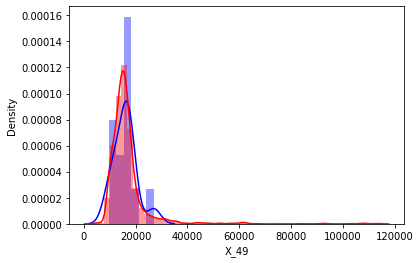

In [34]:
sns.distplot(train_x_spec_y_01['X_49'], color = 'blue')
sns.distplot(train_x_normal_y_01['X_49'], color = 'red')
plt.show()

In [52]:
train_x[train_x['X_57'] == 1].count()

X_01    1250
X_02    1250
X_03    1250
X_04    1250
X_05    1250
X_06    1250
X_07    1250
X_08    1250
X_09    1250
X_10    1250
X_11    1250
X_12    1250
X_13    1250
X_14    1250
X_15    1250
X_16    1250
X_17    1250
X_18    1250
X_19    1250
X_20    1250
X_21    1250
X_22    1250
X_23    1250
X_24    1250
X_25    1250
X_26    1250
X_27    1250
X_28    1250
X_29    1250
X_30    1250
X_31    1250
X_32    1250
X_33    1250
X_34    1250
X_35    1250
X_36    1250
X_37    1250
X_38    1250
X_39    1250
X_40    1250
X_41    1250
X_42    1250
X_43    1250
X_44    1250
X_45    1250
X_46    1250
X_47    1250
X_48    1250
X_49    1250
X_50    1250
X_51    1250
X_52    1250
X_53    1250
X_54    1250
X_55    1250
X_56    1250
X_57    1250
dtype: int64

In [24]:

cols_with_zero_variance = zero_variance(train_x)
train_x = train_x.drop(cols_with_zero_variance, axis = 1)
test_x = test_x.drop(cols_with_zero_variance, axis = 1)

#highly_correlated = [i[1] for i in get_top_correlation(train_x, 7).index]
print(highly_correlated)
#train_x = train_x.drop(highly_correlated, axis = 1)

#test_x = test_x.drop(highly_correlated, axis = 1)
test_x = test_x.drop('ID', axis=1)

['X_11', 'X_18', 'X_18', 'X_21', 'X_15', 'X_22', 'X_26']


In [25]:
group1 = ['X_14', 'X_15', 'X_16',  'X_18']
group2 = [ 'X_20', 'X_21', 'X_22']
group3 = ['X_24',  'X_26', 'X_27', 'X_28', 'X_29']
group4 = ['X_41','X_42', 'X_44']
group5 = ['X_50', 'X_51',  'X_53', 'X_54', 'X_55', 'X_56']

In [29]:
train_x = train_x.drop(group1, axis=1)
train_x = train_x.drop(group2, axis=1)
train_x = train_x.drop(group3, axis=1)
train_x = train_x.drop(group4, axis=1)
train_x = train_x.drop(group5, axis=1)

C:\Users\Dohyeong Seo\AppData\Local\Temp\ipykernel_17900\658759966.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


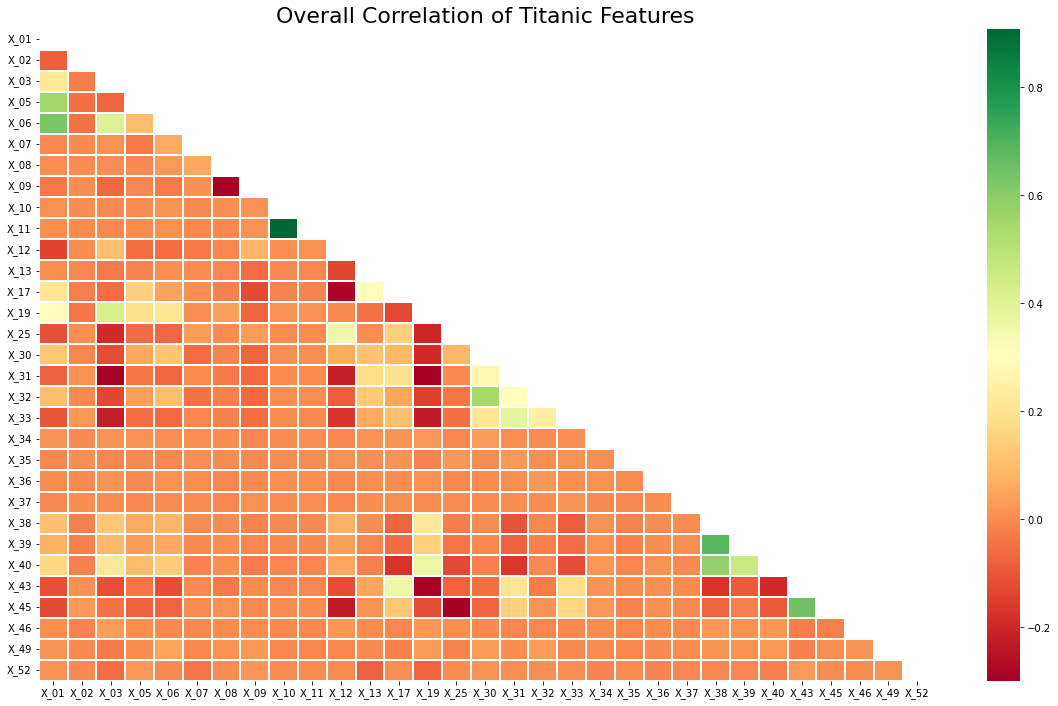

In [35]:
# Co-relation 매트릭스
corr = train_x.corr()
# 마스크 셋업
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 그래프 셋업
plt.figure(figsize=(20, 12))
# 그래프 타이틀
plt.title('Overall Correlation of Titanic Features', fontsize=22)
# Co-relation 매트릭스 런칭
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

In [31]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'subsample': '{:.3f}'.format(params['subsample']),
        'min_split_gain': '{:.3f}'.format(params['min_split_gain']),
        'scale_pos_weight': '{:.3f}'.format(params['scale_pos_weight']),
        'reg_alpha': '{:.3f}'.format(params['reg_alpha']),
        'reg_lambda': '{:.3f}'.format(params['reg_lambda']),
        'learning_rate': '{:.3f}'.format(params['learning_rate']),
        
    }
    
    model = MultiOutputRegressor(LGBMRegressor(n_jobs = -1, random_state = 1, **params))
    
    loss = -cross_val_score(model, train_x, train_y, cv=10, scoring=make_scorer(lg_nrmse, greater_is_better=False)).mean()
    print("NRMSE Loss {:.5f} params {}".format(loss, params))
    return loss

In [32]:
space = {
    'n_estimators' : hp.quniform('n_estimators', 100, 1500, 50),
    'max_depth': hp.quniform('max_depth', 3, 100, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 10),
    'min_child_samples': hp.quniform('min_child_samples', 10, 300, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample': hp.uniform('subsample', 0.3, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.7),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 100),
    'reg_lambda': hp.uniform('reg_lambda', 0, 100),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
}

best = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 200,
            rstate=np.random.default_rng(1))

NRMSE Loss 1.94938 params {'n_estimators': 1350, 'max_depth': 47, 'num_leaves': 20, 'min_child_samples': 240, 'colsample_bytree': '0.715', 'subsample': '0.657', 'min_split_gain': '0.655', 'scale_pos_weight': '4.117', 'reg_alpha': '22.649', 'reg_lambda': '55.509', 'learning_rate': '0.042'}
NRMSE Loss 1.94789 params {'n_estimators': 1500, 'max_depth': 13, 'num_leaves': 90, 'min_child_samples': 110, 'colsample_bytree': '0.538', 'subsample': '0.901', 'min_split_gain': '0.652', 'scale_pos_weight': '7.202', 'reg_alpha': '1.693', 'reg_lambda': '75.762', 'learning_rate': '0.159'}
NRMSE Loss 1.95821 params {'n_estimators': 250, 'max_depth': 67, 'num_leaves': 80, 'min_child_samples': 170, 'colsample_bytree': '0.387', 'subsample': '0.902', 'min_split_gain': '0.436', 'scale_pos_weight': '8.879', 'reg_alpha': '86.379', 'reg_lambda': '88.854', 'learning_rate': '0.039'}
NRMSE Loss 1.95636 params {'n_estimators': 600, 'max_depth': 27, 'num_leaves': 60, 'min_child_samples': 120, 'colsample_bytree': '0.

NRMSE Loss 1.94610 params {'n_estimators': 800, 'max_depth': 55, 'num_leaves': 30, 'min_child_samples': 230, 'colsample_bytree': '0.990', 'subsample': '0.485', 'min_split_gain': '0.273', 'scale_pos_weight': '4.416', 'reg_alpha': '26.844', 'reg_lambda': '56.196', 'learning_rate': '0.021'}
NRMSE Loss 1.93983 params {'n_estimators': 450, 'max_depth': 100, 'num_leaves': 70, 'min_child_samples': 290, 'colsample_bytree': '0.683', 'subsample': '0.645', 'min_split_gain': '0.279', 'scale_pos_weight': '3.718', 'reg_alpha': '0.281', 'reg_lambda': '2.920', 'learning_rate': '0.034'}
NRMSE Loss 1.94707 params {'n_estimators': 650, 'max_depth': 38, 'num_leaves': 100, 'min_child_samples': 60, 'colsample_bytree': '0.312', 'subsample': '0.953', 'min_split_gain': '0.473', 'scale_pos_weight': '7.720', 'reg_alpha': '13.503', 'reg_lambda': '71.472', 'learning_rate': '0.094'}
NRMSE Loss 1.94970 params {'n_estimators': 200, 'max_depth': 69, 'num_leaves': 80, 'min_child_samples': 190, 'colsample_bytree': '0.80

NRMSE Loss 1.95622 params {'n_estimators': 200, 'max_depth': 53, 'num_leaves': 100, 'min_child_samples': 110, 'colsample_bytree': '0.737', 'subsample': '0.477', 'min_split_gain': '0.171', 'scale_pos_weight': '5.243', 'reg_alpha': '52.753', 'reg_lambda': '36.577', 'learning_rate': '0.013'}
NRMSE Loss 1.94556 params {'n_estimators': 900, 'max_depth': 96, 'num_leaves': 50, 'min_child_samples': 70, 'colsample_bytree': '0.827', 'subsample': '0.859', 'min_split_gain': '0.390', 'scale_pos_weight': '5.551', 'reg_alpha': '32.014', 'reg_lambda': '57.213', 'learning_rate': '0.032'}
NRMSE Loss 1.94418 params {'n_estimators': 750, 'max_depth': 75, 'num_leaves': 90, 'min_child_samples': 130, 'colsample_bytree': '0.927', 'subsample': '0.970', 'min_split_gain': '0.301', 'scale_pos_weight': '2.202', 'reg_alpha': '23.902', 'reg_lambda': '95.999', 'learning_rate': '0.015'}
NRMSE Loss 1.95405 params {'n_estimators': 400, 'max_depth': 41, 'num_leaves': 80, 'min_child_samples': 30, 'colsample_bytree': '0.61

NRMSE Loss 1.94296 params {'n_estimators': 700, 'max_depth': 54, 'num_leaves': 50, 'min_child_samples': 200, 'colsample_bytree': '0.716', 'subsample': '0.340', 'min_split_gain': '0.190', 'scale_pos_weight': '8.413', 'reg_alpha': '19.972', 'reg_lambda': '72.227', 'learning_rate': '0.053'}
NRMSE Loss 1.93964 params {'n_estimators': 350, 'max_depth': 95, 'num_leaves': 90, 'min_child_samples': 170, 'colsample_bytree': '0.987', 'subsample': '0.671', 'min_split_gain': '0.031', 'scale_pos_weight': '7.174', 'reg_alpha': '12.984', 'reg_lambda': '64.856', 'learning_rate': '0.067'}
NRMSE Loss 1.95094 params {'n_estimators': 850, 'max_depth': 92, 'num_leaves': 60, 'min_child_samples': 240, 'colsample_bytree': '0.419', 'subsample': '0.812', 'min_split_gain': '0.226', 'scale_pos_weight': '3.318', 'reg_alpha': '41.932', 'reg_lambda': '85.430', 'learning_rate': '0.138'}
NRMSE Loss 1.94846 params {'n_estimators': 500, 'max_depth': 68, 'num_leaves': 70, 'min_child_samples': 140, 'colsample_bytree': '0.9

NRMSE Loss 1.94437 params {'n_estimators': 750, 'max_depth': 73, 'num_leaves': 90, 'min_child_samples': 10, 'colsample_bytree': '0.767', 'subsample': '0.666', 'min_split_gain': '0.262', 'scale_pos_weight': '9.755', 'reg_alpha': '41.195', 'reg_lambda': '34.372', 'learning_rate': '0.010'}
NRMSE Loss 1.95020 params {'n_estimators': 900, 'max_depth': 58, 'num_leaves': 100, 'min_child_samples': 160, 'colsample_bytree': '0.470', 'subsample': '0.823', 'min_split_gain': '0.409', 'scale_pos_weight': '5.103', 'reg_alpha': '44.457', 'reg_lambda': '17.190', 'learning_rate': '0.043'}
NRMSE Loss 1.94349 params {'n_estimators': 600, 'max_depth': 28, 'num_leaves': 60, 'min_child_samples': 110, 'colsample_bytree': '0.679', 'subsample': '0.958', 'min_split_gain': '0.454', 'scale_pos_weight': '8.419', 'reg_alpha': '6.954', 'reg_lambda': '40.022', 'learning_rate': '0.074'}
NRMSE Loss 1.94537 params {'n_estimators': 250, 'max_depth': 84, 'num_leaves': 80, 'min_child_samples': 240, 'colsample_bytree': '0.80

NRMSE Loss 1.93898 params {'n_estimators': 800, 'max_depth': 97, 'num_leaves': 50, 'min_child_samples': 90, 'colsample_bytree': '0.853', 'subsample': '0.415', 'min_split_gain': '0.126', 'scale_pos_weight': '6.619', 'reg_alpha': '12.457', 'reg_lambda': '50.166', 'learning_rate': '0.044'}
NRMSE Loss 1.95105 params {'n_estimators': 1150, 'max_depth': 74, 'num_leaves': 70, 'min_child_samples': 40, 'colsample_bytree': '0.975', 'subsample': '0.943', 'min_split_gain': '0.187', 'scale_pos_weight': '5.763', 'reg_alpha': '89.318', 'reg_lambda': '38.008', 'learning_rate': '0.032'}
NRMSE Loss 1.94605 params {'n_estimators': 650, 'max_depth': 24, 'num_leaves': 30, 'min_child_samples': 280, 'colsample_bytree': '0.665', 'subsample': '0.632', 'min_split_gain': '0.007', 'scale_pos_weight': '5.519', 'reg_alpha': '55.523', 'reg_lambda': '2.869', 'learning_rate': '0.058'}
NRMSE Loss 1.94344 params {'n_estimators': 450, 'max_depth': 57, 'num_leaves': 80, 'min_child_samples': 150, 'colsample_bytree': '0.743

NRMSE Loss 1.93947 params {'n_estimators': 200, 'max_depth': 21, 'num_leaves': 100, 'min_child_samples': 40, 'colsample_bytree': '0.626', 'subsample': '0.305', 'min_split_gain': '0.143', 'scale_pos_weight': '2.333', 'reg_alpha': '17.808', 'reg_lambda': '67.156', 'learning_rate': '0.048'}
NRMSE Loss 1.96222 params {'n_estimators': 100, 'max_depth': 7, 'num_leaves': 90, 'min_child_samples': 10, 'colsample_bytree': '0.354', 'subsample': '0.439', 'min_split_gain': '0.326', 'scale_pos_weight': '4.361', 'reg_alpha': '1.877', 'reg_lambda': '80.320', 'learning_rate': '0.015'}
NRMSE Loss 1.94126 params {'n_estimators': 450, 'max_depth': 10, 'num_leaves': 100, 'min_child_samples': 50, 'colsample_bytree': '0.694', 'subsample': '0.394', 'min_split_gain': '0.176', 'scale_pos_weight': '2.641', 'reg_alpha': '9.432', 'reg_lambda': '96.250', 'learning_rate': '0.104'}
NRMSE Loss 1.95459 params {'n_estimators': 350, 'max_depth': 6, 'num_leaves': 80, 'min_child_samples': 100, 'colsample_bytree': '0.808', 

KeyboardInterrupt: 

In [25]:
model = MultiOutputRegressor(LGBMRegressor(n_jobs = -1, random_state = 1, **best))
model.fit(train_x, train_y)
preds = model.predict(test_x)

LightGBMError: Parameter num_iterations should be of type int, got "1100.0"

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]
submit.to_csv('./submission_3.csv', index = False)